In [ ]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt 

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense 
from numpy.random import randn 
from matplotlib import pyplot 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

In [ ]:
data = pd.read_csv('diabetes.csv')
print(data.shape) 
print(data.tail())
print(data.columns)

(768, 9)
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [ ]:
features = data.drop(['Outcome'], axis=1)
label = data['Outcome']

In [ ]:
# get X and y data from data, dataframe. 
X = features.to_numpy()
y = label.to_numpy()

In [ ]:
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
clf_true = RandomForestClassifier(n_estimators=100)
clf_true.fit(X_true_train, y_true_train)

RandomForestClassifier()

In [ ]:
y_true_pred = clf_true.predict(X_true_test)

In [ ]:
print("Base Accuracy:", metrics.accuracy_score(y_true_test, y_true_pred))

Base Accuracy: 0.7359307359307359


In [ ]:
print("Base classification report:", metrics.classification_report(y_true_test, y_true_pred))

Base classification report:               precision    recall  f1-score   support

           0       0.80      0.79      0.80       151
           1       0.62      0.62      0.62        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231



In [ ]:
# In order to generate fake data, 
# We need to create random noise. 
# This will then be reshaped to the input shape 
# of the generator neural network. 
def generate_latent_points(latent_dim, n_samples): 
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
# Generate fake data using the generator. 
# This fake data will later be the input to the 
# discriminator. 
def generate_fake_samples(generator, latent_dim, n_samples): 
  x_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(x_input) 
  y = np.zeros((n_samples, 1))
  return X, y

In [ ]:
# We will also randomly sample n data points 
# from the dataframe using this function. 
def generate_real_samples(n): 
  X = data.sample(n)
  y = np.ones((n, 1))
  return X, y

In [ ]:
# Generator nn architecture 
# 3 dense layers, first with 15 nodes, 
# second with 30 nodes, and last with 9 outputs. 
# the input size is latent_dim. 
def define_generator(latent_dim, n_outputs=9):
  model = Sequential() 
  model.add(Dense(15, activation='relu', 
                  kernel_initializer='he_uniform',
                  input_dim=latent_dim))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(n_outputs, activation='linear'))

  return model 

In [ ]:
generator1 = define_generator(10, 9)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 9)                 279       
                                                                 
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Discriminator nn architecture 
# 3 dense layers, first with 25 nodes, 
# second with 50 nodes, and the last with 1 node. 
# The input size is 9, for 9 columns, that is the output
# of the generator nn. 
def define_discriminator(n_inputs=9):
  model = Sequential()
  model.add(Dense(25, activation='relu', 
                  kernel_initializer='he_uniform', 
                  input_dim=n_inputs))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
  return model 

In [ ]:
discriminator1 = define_discriminator(9)
discriminator1.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 25)                250       
                                                                 
 dense_5 (Dense)             (None, 50)                1300      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# GAN nn architecture. 
# We do NOT want to train the discriminator. 
# We basically connect the generator and 
# the discriminator, with BCE loss and Adam optimizer. 
# Only training the weights of the generator. 
def define_gan(generator, discriminator): 
  # Keep the discriminator weights constant.
  # set to false before compilation of model. 
  discriminator.trainable=False
  model = Sequential() 
  model.add(generator) 
  model.add(discriminator) 
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model 

In [ ]:
# plot the training history for generator 
# and discriminator on the same graph. 
def plot_history(d_hist, g_hist): 
  plt.subplot(1, 1, 1)
  plt.plot(d_hist, label='d')
  plt.plot(g_hist, label='gen')
  plt.show()
  plt.close() 

In [ ]:
# The training session. 
# epochs = 10,000
# batch size = 128
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, 
          n_batch=128, n_eval=200):
  half_batch = int(n_batch/2)
  d_history = []
  g_history = []

  for epoch in range(n_epochs): 
    # generate real samples of size 64. 
    x_real, y_real = generate_real_samples(half_batch)
    # generate fake samples of size 64.
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, 
                                           half_batch)
    
    # train on real data and find loss and accuracy. 
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    # train on fake data and find loss and accuracy. 
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    # overall loss of discriminator is average of real and fake data. 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

    # generate noise and a label of 1s. 
    x_gan = generate_latent_points(latent_dim, n_batch) 
    y_gan = np.ones((n_batch, 1))

    # the loss of fake data
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan) 

    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % 
          (epoch+1, d_loss_real, d_loss_fake, d_loss, g_loss_fake))

    # add the data to the discriminator and generator's history for
    # plotting later. 
    d_history.append(d_loss)
    g_history.append(g_loss_fake) 

  plot_history(d_history, g_history) # plot the diagram of the training process. 

  g_model.save('trained_generated_model.h5')

Streaming output truncated to the last 5000 lines.
>5001, d1=0.432, d2=0.340 d=0.386 g=1.781
>5002, d1=0.410, d2=0.331 d=0.370 g=1.581
>5003, d1=0.287, d2=0.464 d=0.376 g=1.577
>5004, d1=0.221, d2=0.296 d=0.259 g=2.029
>5005, d1=0.358, d2=0.348 d=0.353 g=2.075
>5006, d1=0.388, d2=0.318 d=0.353 g=2.066
>5007, d1=0.580, d2=0.349 d=0.464 g=1.468
>5008, d1=0.311, d2=0.681 d=0.496 g=1.505
>5009, d1=0.312, d2=0.550 d=0.431 g=1.897
>5010, d1=0.970, d2=0.448 d=0.709 g=1.866
>5011, d1=0.849, d2=0.480 d=0.664 g=1.265
>5012, d1=0.590, d2=0.962 d=0.776 g=1.032
>5013, d1=0.614, d2=0.900 d=0.757 g=1.287
>5014, d1=0.954, d2=0.657 d=0.806 g=1.544
>5015, d1=1.315, d2=0.467 d=0.891 g=1.347
>5016, d1=1.276, d2=1.075 d=1.175 g=0.948
>5017, d1=0.717, d2=1.062 d=0.890 g=0.952
>5018, d1=0.771, d2=0.727 d=0.749 g=1.377
>5019, d1=1.069, d2=0.562 d=0.816 g=1.064
>5020, d1=0.993, d2=1.005 d=0.999 g=0.781
>5021, d1=0.333, d2=0.951 d=0.642 g=1.169
>5022, d1=0.581, d2=0.386 d=0.484 g=1.807
>5023, d1=0.849, d2=0.291

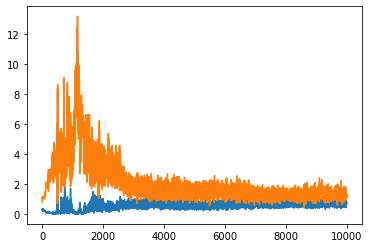

In [ ]:
latent_dim = 10 
discriminator = define_discriminator() 
generator = define_generator(latent_dim) 
gan_model = define_gan(generator, discriminator) 
train(generator, discriminator, gan_model, latent_dim)

In [ ]:
# load the saved model. 
from keras.models import load_model 
model = load_model('trained_generated_model.h5')

In [ ]:
# Generate noise 
# the input, X, is the the output of the model. 
latent_points = generate_latent_points(10, 750)
X = model.predict(latent_points)

data_fake = pd.DataFrame(data=X,  columns=['Pregnancies', 'Glucose', 
                                           'BloodPressure', 'SkinThickness', 
                                           'Insulin', 'BMI', 
                                           'DiabetesPedigreeFunction', 
                                           'Age', 'Outcome'])
data_fake.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.7053,101.5312,58.8502,32.1088,0.1435,26.8319,1.2599,18.2250,0.7301
1,8.1516,103.1386,70.7630,28.0533,57.0949,28.0963,1.5000,49.4504,1.2010
2,-0.8663,128.1567,63.7744,16.4066,-0.0683,24.4401,1.1543,23.3047,0.8033
3,-3.3773,197.6106,148.6528,65.3958,317.8243,74.8866,2.8282,46.8928,1.9403
4,4.8690,233.1021,162.7065,73.7372,-1.0836,67.1239,2.3459,56.2856,1.8825
5,-2.2933,148.3229,82.8810,33.7989,97.3976,32.8595,1.4299,18.7346,0.9780
6,5.2300,92.9729,44.8442,25.7772,66.1676,23.2314,1.3657,30.4970,1.2086
7,-2.0076,101.7843,61.2623,7.8395,76.0286,26.4906,0.9918,16.9007,0.7737
8,-1.5469,90.5824,46.3293,15.3683,140.8080,20.7303,0.9573,14.8954,0.6684
9,6.7511,154.3173,120.5072,45.4593,0.2171,50.5579,1.6869,51.6874,1.3953


In [ ]:
outcome_mean = data_fake.Outcome.mean() 

# After calculating threshold, convert to boolean values. 
data_fake['Outcome'] = data_fake['Outcome'] > outcome_mean
data_fake['Outcome'] = data_fake['Outcome'].astype(int) 

In [ ]:
data_fake.head() 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.413327,64.427528,61.250854,30.435595,3.922277,38.114731,1.797965,37.594284,0
1,-0.651548,64.388931,48.437687,5.532092,32.030586,16.814693,0.485869,16.130213,0
2,2.968016,75.393669,56.090946,20.617352,-0.072583,23.445002,0.835029,24.697044,0
3,9.484409,67.057343,81.057083,25.724577,5.939246,42.618942,1.619208,53.413597,0
4,0.390664,106.264412,66.514809,46.906094,77.168320,39.718624,1.734486,18.610468,0


In [ ]:
features = data_fake.drop(['Outcome'], axis=1)
label = data_fake['Outcome']

X_fake_created = features.to_numpy() 
y_fake_created = label.to_numpy() 

In [ ]:
X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake_created, y_fake_created, test_size=0.30, random_state=42)
clf_fake = RandomForestClassifier(n_estimators=100)
clf_fake.fit(X_fake_train, y_fake_train) 

y_fake_pred = clf_fake.predict(X_fake_test) 

print("Accuracy of fake data model:",metrics.accuracy_score(y_fake_test, y_fake_pred))
print("Classification report of fake data model:",metrics.classification_report(y_fake_test, y_fake_pred))

Accuracy of fake data model: 0.9555555555555556
Classification report of fake data model:               precision    recall  f1-score   support

           0       0.95      0.97      0.96       129
           1       0.96      0.94      0.95        96

    accuracy                           0.96       225
   macro avg       0.96      0.95      0.95       225
weighted avg       0.96      0.96      0.96       225



In [ ]:
!pip install table_evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 5.2 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [ ]:
from table_evaluator import load_data, TableEvaluator 

table_evaluator = TableEvaluator(data, data_fake) 
table_evaluator.evaluate(target_col='Outcome')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6733   0.9267              0.5306
DecisionTreeClassifier_real   0.7600   0.6000              0.4423
LogisticRegression_fake       0.9000   0.9267              0.8293
LogisticRegression_real       0.8133   0.6467              0.4634
MLPClassifier_fake            0.6000   0.8400              0.5000
MLPClassifier_real            0.7533   0.5933              0.3636
RandomForestClassifier_fake   0.7200   0.9067              0.5957
RandomForestClassifier_real   0.8000   0.7533              0.6760

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.5314
nearest neighbor std                     0.7299

Miscellaneous results:
                                  Result
Column Cor

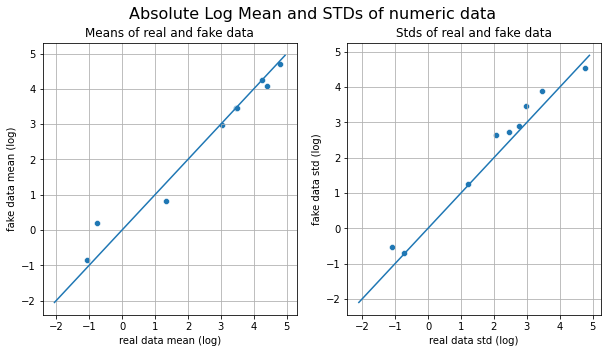

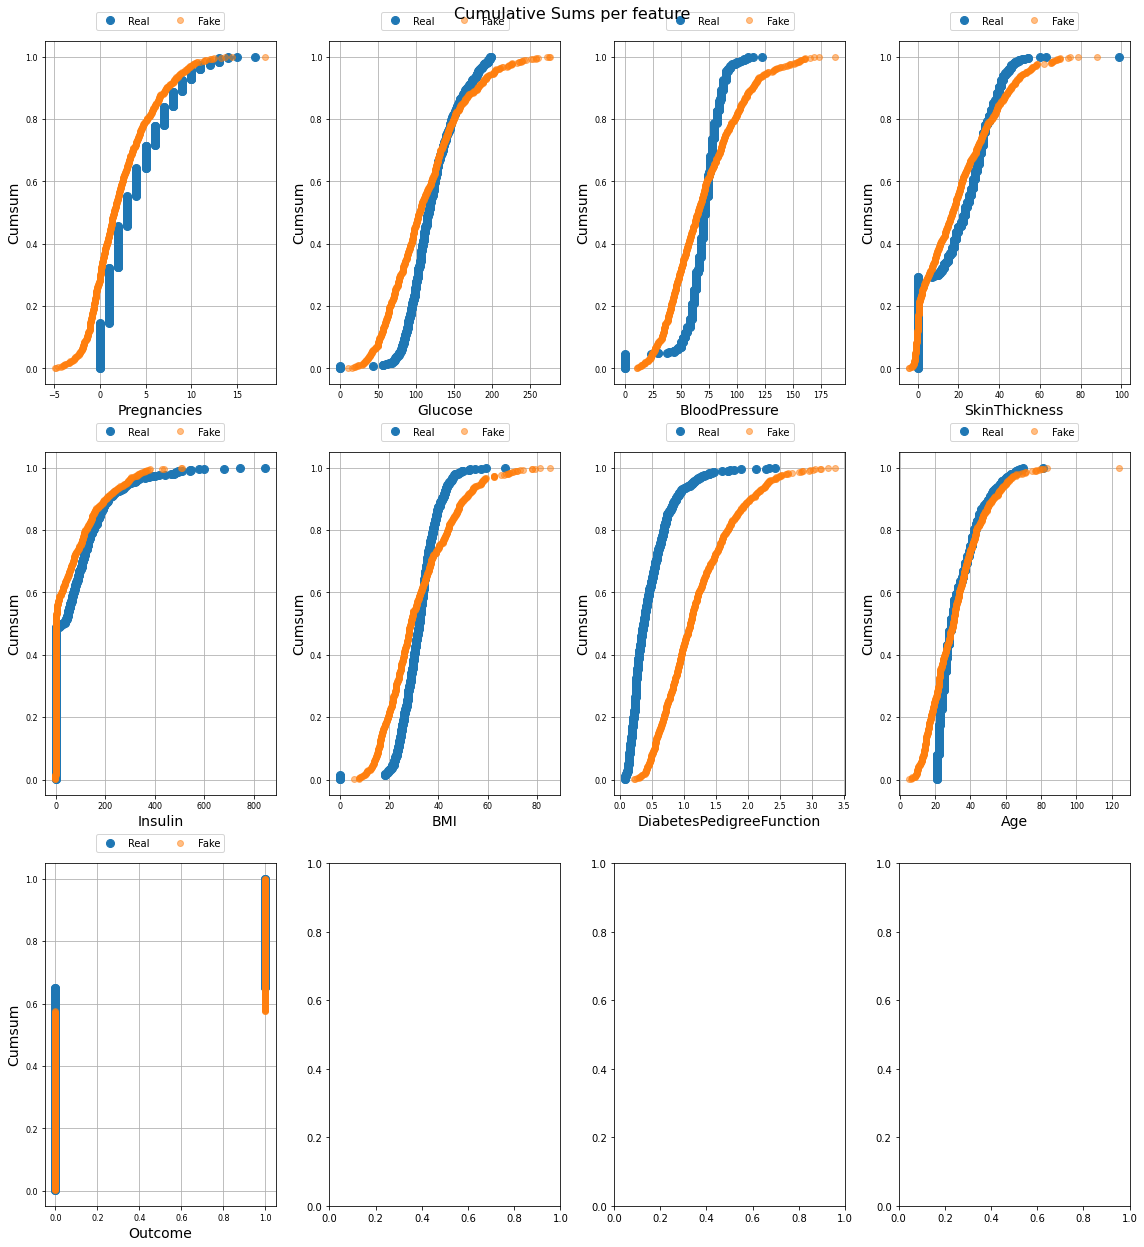

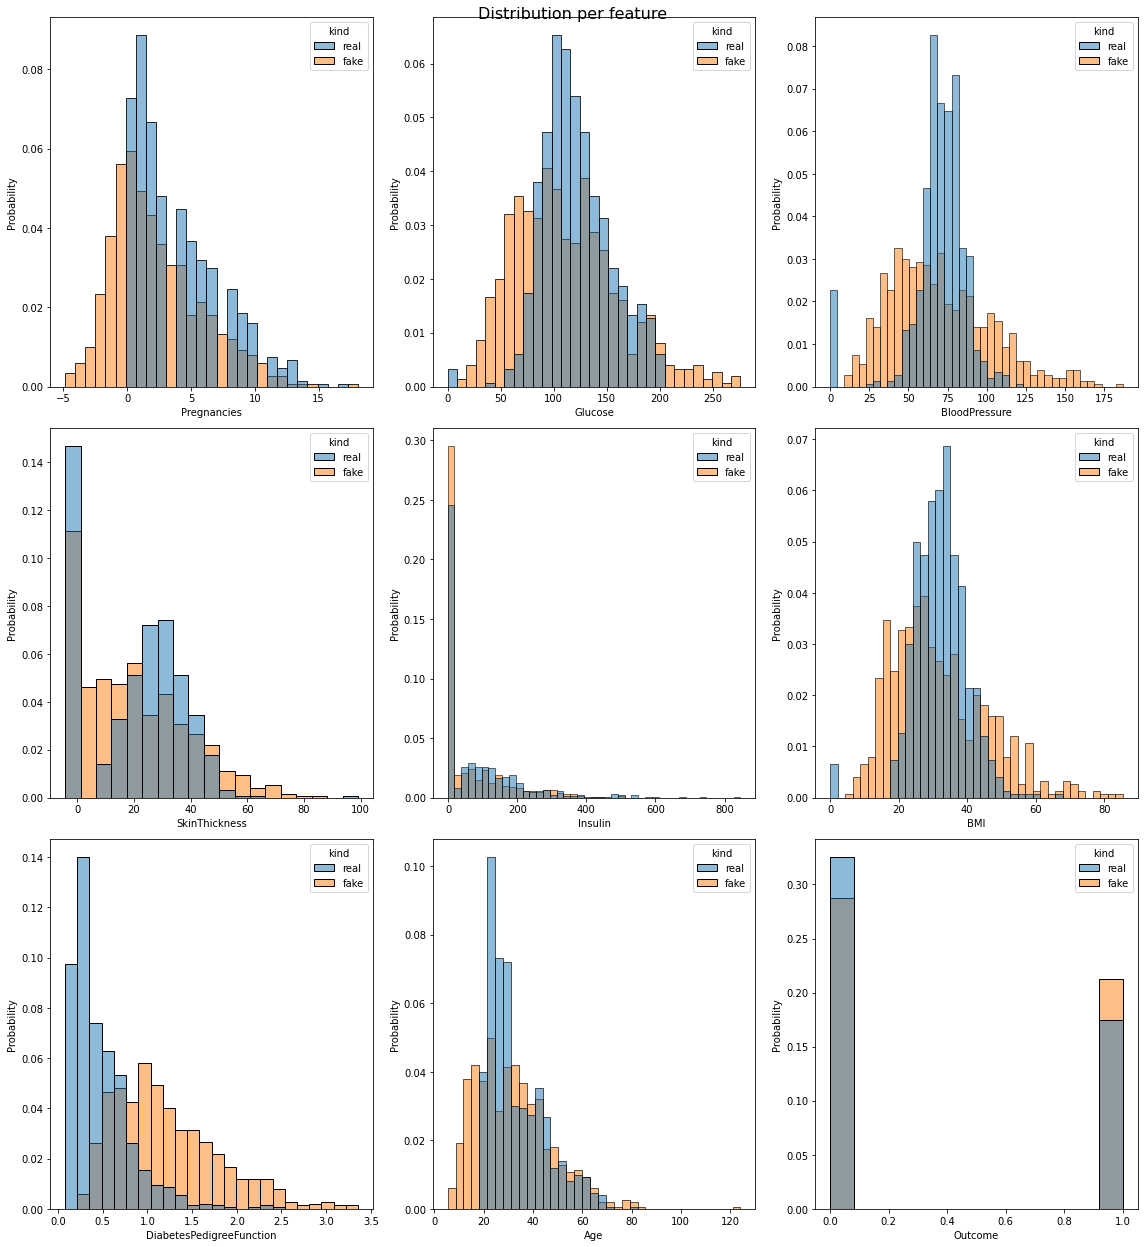

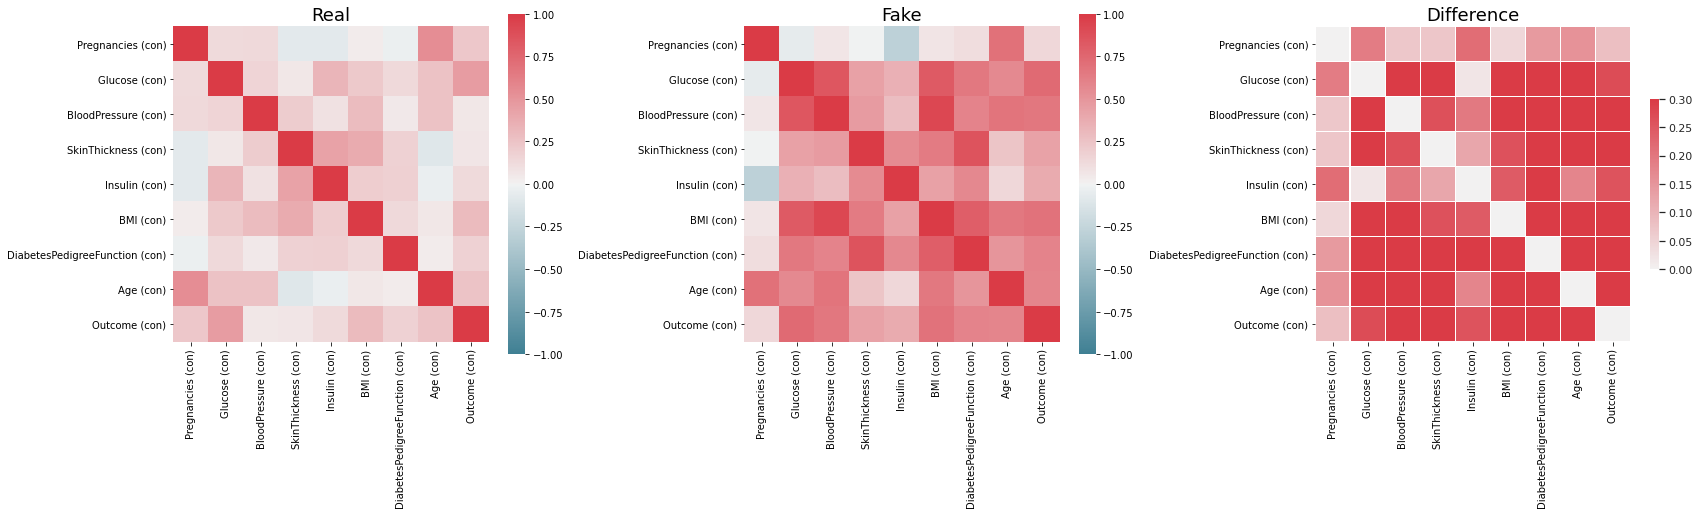

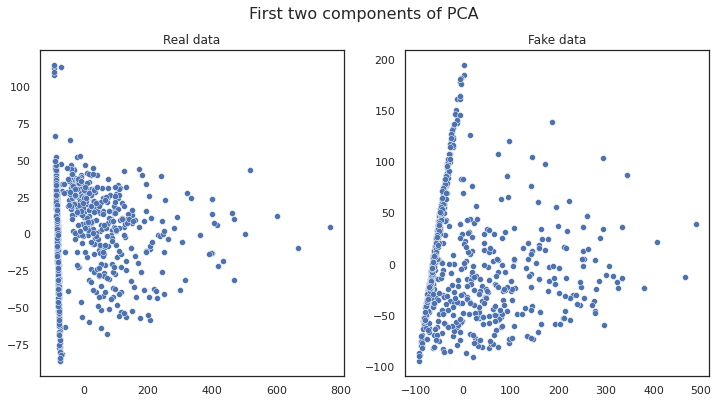

In [ ]:
table_evaluator.visual_evaluation() 